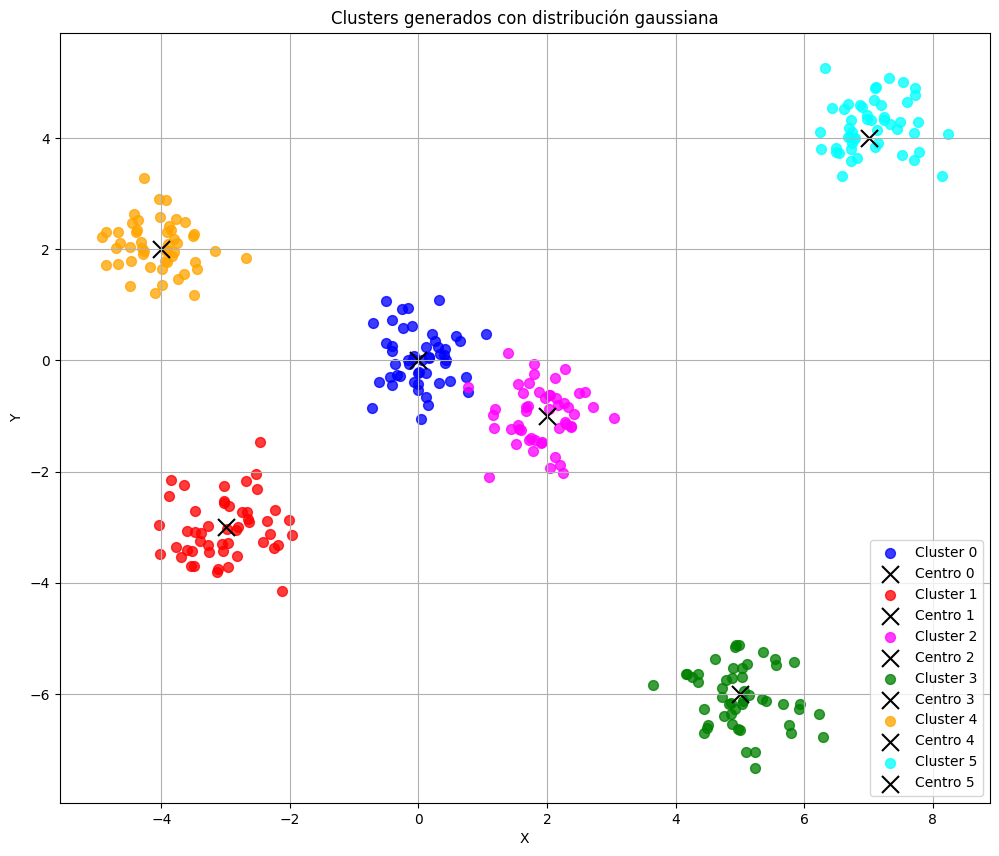

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos los centros de los clusters
centros = [
    [0, 0],
    [-3, -3],
    [2, -1],
    [5, -6],
    [-4, 2],
    [7, 4]
]

def generar_datos_gaussianos(n_muestras=100, n_clusters=3, centros=None):
    """
    Genera datos sintéticos siguiendo distribuciones gaussianas.

    Parámetros:
    -----------
    n_muestras : int
        Cantidad de puntos para cada cluster.
    n_clusters : int
        Número de clusters a generar.
    centros : array 
        Coordenadas de los centros (x, y).

    Retorna:
    --------
    X : array
        Coordenadas (x, y) de todos los puntos.
    y : array
        Etiqueta del cluster al que pertenece cada punto.
    """
    X = []
    y = []
    for i in range(n_clusters):
        puntos_x = np.random.normal(centros[i][0], 0.5, n_muestras)
        puntos_y = np.random.normal(centros[i][1], 0.5, n_muestras)
        etiquetas = np.full(n_muestras, i)  # Generamos las etiquetas correctas
        puntos = np.column_stack((puntos_x, puntos_y))  # Creamos un array (N,2)
        X.append(puntos)
        y.append(etiquetas)

    X = np.vstack(X)
    y = np.hstack(y)

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

def visualizar_datos(X, y, centros, n_clusters):
    """
    Visualiza los clusters generados junto con sus centros.

    Parámetros:
    -----------
    X : array
        Coordenadas (x, y) de todos los puntos.
    y : array
        Etiqueta del cluster al que pertenece cada punto.
    centros : array
        Coordenadas de los centros de los clusters.
    n_clusters : int
        Número de clusters a visualizar.
    """
    plt.figure(figsize=(12, 10))
    colores = ["blue", "red", "magenta", "green", "orange", "cyan", "purple"]
    colores = colores[:n_clusters]  # Limitamos la cantidad de colores a los clusters existentes

    for i, c in enumerate(colores):
        mask = (y == i)
        plt.scatter(X[mask, 0], X[mask, 1], color=c, s=50, alpha=0.77, label=f'Cluster {i}')
        plt.scatter(centros[i][0], centros[i][1], color="black", marker='x', s=150, label=f'Centro {i}')

    plt.legend()
    plt.title("Clusters generados con distribución gaussiana")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

# Definir la cantidad de clusters basada en los centros
n_clusters = len(centros)

# Generamos los datos y los visualizamos
X, Y = generar_datos_gaussianos(50, n_clusters, centros)
visualizar_datos(X, Y, centros, n_clusters)

In [15]:
import numpy as np
class DeterministicAnnealing:
    def init(self, n_clusters=3, T_min=0.01, T_max=5.0, epsilon=1e-6, max_iter=100):
        """
        Implementación del algoritmo Deterministic Annealing para clustering.
        
        Parámetros:
        -----------
        n_clusters : int
            Número de clusters a encontrar
        T_min : float
            Temperatura mínima para detener el enfriamiento
        T_max : float
            Temperatura inicial
        epsilon : float
            Umbral de convergencia para la matriz de pertenencia
        max_iter : int
            Número máximo de iteraciones
        """
        self.n_clusters = n_clusters
        self.T_min = T_min
        self.T_max = T_max
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.centroids = None
        self.M = None  # Matriz de pertenencia

    def _calcular_entropia_por_puntos(self):
        return -np.sum(self.M * np.log(self.M)) / len(self.M)

    def _calcular_entropia_por_cluster(self):
        entropia_total = 0
        lista_entropia_por_clusters = []
        for i in range(self.m_clusters):
            p_c = np.sum(self.M[:,i]) / len(self.M)
            p_x_dado_c = self.M[:,i]/np.sum(self.M[:,i])
            entropia_por_c = -np.sum(p_x_dado_c * np.log(p_x_dado_c))
            lista_entropia_por_clusters.append(entropia_por_c)
            entropia_total += p_c * entropia_por_c
        return entropia_total, np.array(lista_entropia_por_clusters)
            
    
    def _calcular_distancia(self, X, centroides):
        """
        Calcula la matriz de distancias euclidianas al cuadrado entre puntos y centroides.
        
        Utilizamos la identidad: ||a-b||² = ||a||² + ||b||² - 2<a,b>
        donde <a,b> es el producto escalar.
        """
        norma_x = np.sum(X**2, axis=1, keepdims=True)
        norma_c = np.sum(centroides**2, axis=1, keepdims=True)
        producto_escalar = np.dot(X, centroides.T)
        distancias =  norma_x + norma_c - 2*producto_escalar
        # Evitar errores numéricos
        return np.maximum(distancias, 0)
    
    def _actualizar_pertenencia(self, X, centroides, T):
        """
        Actualiza la matriz de pertenencia (probabilidades).
        
        Esta es la parte clave del algoritmo deterministic annealing:
        la probabilidad de pertenencia depende de la distancia y la temperatura.
        """

        D = self._calcular_distancia(X, centroides)
        beta = 1/T
        numerador = np.exp(-beta*D)
        denominador = np.sum(np.exp(-beta*D))
        M = numerador / (denominador + 1e-10)
        
        return M
    
    def _actualizar_centroides(self, X, M):
        """
        Actualiza las posiciones de los centroides basado en la matriz de pertenencia.
        
        Cada centroide se actualiza como un promedio ponderado de todos los puntos,
        donde los pesos son las probabilidades de pertenencia.
        """
        numerador = np.dot(M.T,X) # (n_muestrasxclster) (n_muestrasx2)
        denominador = np.sum(M, axis=0)[:,None] # (n_muestras,)
        cen = numerador / (denominador + 1e-10)
        return cen
    
    def fit(self, X):
        """
        Ajusta el modelo de Deterministic Annealing a los datos.
        
        Proceso:
        1. Inicializar centroides y temperatura
        2. Bucle principal de annealing:
           - Calcular matriz de pertenencia
           - Actualizar centroides
           - Reducir temperatura
           - Verificar convergencia
        """
        n_muestras, n_dimensiones = X.shape
      
        self.centroids = np.random.randn(self.n_clusters, n_dimensiones)
        
        # Inicializar parámetros para el bucle
        t = 0  # Contador de iteraciones
        T = self.T_max  # Temperatura inicial
        convergencia = False
        M_anterior = np.ones((n_muestras, self.n_clusters)) / self.n_clusters
        
        # Bucle principal
        while not convergencia:
            # Actualizar matriz de pertenencia con temperatura actual
            self.M =self._actualizar_pertenencia(X, self.centroids, T)
            # Actualizar centroides
            self.centroids = self._actualizar_centroides(X, self.M)
            
            # Actualizar contador y temperatura
            t += 1
            T = 1/np.log(1+t) 
            
            # Verificar convergencia
            diferencia = np.sum(np.abs(self.M - M_anterior))
            if (T<self.T_min) or (t > self.T_max) or (diferencia <= self.epsilon):
                convergencia = True
            
            # Guardar matriz actual para próxima iteración
            M_anterior = self.M.copy()
        
        return self
    
    def predict(self, X):
        """
        Predice el cluster para cada punto en X.
        
        Retorna el índice del cluster con mayor probabilidad para cada punto.
        """
        M = self._actualizar_pertenencia(X, self.centroids, self.T_min)
        return np.argmax(M, axis=1)
    
    def fit_predict(self, X):
        """
        Ajusta el modelo y predice los clusters en un solo paso.
        """
        self.fit(X)
        return self.predict(X)

In [16]:
def calcular_entropia_por_punto(self):
    """
    Calcula la entropía condicional H(C|X), que es la entropía por punto.
    
    Esta entropía mide la incertidumbre en la asignación de clusters para cada punto.
    """
    # Evitamos problemas numéricos con log(0)
    M_safe = np.clip(self.M, 1e-10, 1.0)
    
    # Calculamos la entropía para cada punto: -sum(p * log(p))
    entropias = -np.sum(M_safe * np.log(M_safe), axis=1)
    
    # Calculamos el promedio de entropía
    entropia_promedio = np.mean(entropias)
    
    return entropia_promedio, entropias
    
def calcular_entropia_por_cluster(self):
    """
    Calcula la entropía condicional H(X|C), que es la entropía por cluster.
    
    Esta entropía mide qué tan uniforme es la distribución de puntos dentro de cada cluster.
    También devuelve un array con las entropías individuales de cada cluster.
    """
    entropia_total = 0
    lista_entropia_por_clusters = []
    
    # Para cada cluster calculamos su entropía
    for i in range(self.n_clusters):
        # Probabilidad del cluster (p(c))
        p_c = np.sum(self.M[:,i]) / len(self.M)
        
        # Si el cluster está vacío, su entropía es 0
        if p_c < 1e-10:
            lista_entropia_por_clusters.append(0)
            continue
        
        # Probabilidad de cada punto dado el cluster (p(x|c))
        p_x_dado_c = self.M[:,i] / np.sum(self.M[:,i])
        
        # Evitamos problemas numéricos
        p_x_dado_c = np.clip(p_x_dado_c, 1e-10, 1.0)
        
        # Entropía del cluster
        entropia_por_c = -np.sum(p_x_dado_c * np.log(p_x_dado_c))
        lista_entropia_por_clusters.append(entropia_por_c)
        
        # Contribución a la entropía total (ponderada)
        entropia_total += p_c * entropia_por_c
    
    return entropia_total, np.array(lista_entropia_por_clusters)

In [17]:
def automated_clustering(X, max_clusters=10):
    """
    Implementa el método del codo para encontrar el número óptimo de clusters
    utilizando entropía como métrica.
    
    Parámetros:
    -----------
    X : array
        Datos para clustering
    max_clusters : int
        Número máximo de clusters a evaluar
    
    Retorna:
    --------
    optimo : int
        Número óptimo de clusters
    entropias : list
        Lista con las entropías para cada número de clusters
    """
    # Lista para almacenar las entropías por número de clusters
    entropias = []
    
    # Evaluamos desde 1 hasta max_clusters
    for k in range(1, max_clusters + 1):
        print(f"Evaluando con {k} clusters...")
        
        # Inicializamos y ajustamos el modelo con k clusters
        da = DeterministicAnnealing(n_clusters=k, T_min=0.01, T_max=5.0, 
                                  epsilon=1e-6, max_iter=100)
        da.fit(X)
        
        # Calculamos la entropía promedio por punto
        entropia_promedio, _ = calcular_entropia_por_punto(da)
        entropias.append(entropia_promedio)
        
        print(f"Entropía con {k} clusters: {entropia_promedio:.4f}")
    
    # Detectamos automáticamente el punto del codo
    optimo = detectar_codo(entropias)
    
    return optimo, entropias

def detectar_codo(entropias):
    """
    Detecta el punto de codo en la curva de entropía.
    
    Parámetros:
    -----------
    entropias : list
        Lista de entropías para diferentes números de clusters
    
    Retorna:
    --------
    optimo : int
        Número óptimo de clusters
    """
    # Calculamos las diferencias entre valores consecutivos
    diferencias = np.diff(entropias)
    
    # Normalizamos las diferencias
    diferencias_norm = np.abs(diferencias) / np.max(np.abs(diferencias))
    
    # Buscamos donde la diferencia se estabiliza (cae por debajo de un umbral)
    for i, dif in enumerate(diferencias_norm):
        if dif < 0.2:  # Umbral arbitrario para detectar estabilización
            return i + 1
    
    # Si no se encuentra un codo claro, sugerimos un valor predeterminado
    return 3

def visualizar_metodo_codo(entropias, optimo):
    """
    Visualiza los resultados del método del codo y marca el número óptimo de clusters.
    
    Parámetros:
    -----------
    entropias : list
        Lista de entropías para diferentes números de clusters
    optimo : int
        Número óptimo de clusters determinado
    """
    plt.figure(figsize=(10, 6))
    
    # Gráfico de entropía vs número de clusters
    plt.plot(range(1, len(entropias) + 1), entropias, 'bo-', linewidth=2, markersize=8)
    
    # Línea vertical en el punto óptimo
    plt.axvline(x=optimo, color='g', linestyle='--', linewidth=2, 
               label=f'Número óptimo de clusters: {optimo}')
    
    plt.title('Método del Codo: Entropía vs Número de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Entropía Promedio')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(range(1, len(entropias) + 1))
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
# Generamos datos con un número conocido de clusters
np.random.seed(42)  # Para reproducibilidad
centros_reales = [
    [0, 0],
    [5, 5],
    [0, 5],
    [5, 0]
]
X, y = generar_datos_gaussianos(n_muestras=30, n_clusters=4, centros=centros_reales)

# Aplicamos el método de codo
optimo, entropias = automated_clustering(X, max_clusters=8)
visualizar_metodo_codo(entropias, optimo)

print(f"\nEl número óptimo de clusters encontrado es: {optimo}")
print(f"El número real de clusters es: {len(centros_reales)}")

Evaluando con 1 clusters...


TypeError: DeterministicAnnealing() takes no arguments